# **Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

### Data Processing & Visualization
- **Dataset Distribution Plot** → Confirms balanced data split across training, validation, and test sets.  
- **Data Augmentation Visualization** → Showcases applied transformations (rotation, flipping, zooming).  

### Model Training & Evaluation
- **Baseline CNN Models (Sigmoid & Softmax)** → Initial experiments to establish a benchmark.  
- **MobileNetV2 Fine-Tuning** → Explored optimized architectures with different hyperparameters.  
- **Best Model Selection** → Chose the most balanced model based on test accuracy, generalization, and robustness.  
- **Saved Trained Model** → Final MobileNetV2 model stored for deployment.  

### Model Performance & Explainability
- **Learning Curves** → Visualizes loss and accuracy trends over epochs.  
- **Histograms** → Displays predicted probability distributions.  
- **Overfitting & Generalization Check** → Assesses potential overfitting using accuracy and loss gaps.  
- **Confusion Matrices** → Shows classification performance for train, validation, and test sets.  
- **Classification Reports** → Provides precision, recall, and F1-score analysis.  
- **ROC Curves** → Evaluates model performance using Receiver Operating Characteristic analysis.  
- **Business Goal Validation** → Confirms if the model meets the required accuracy threshold.  

## Additional Comments

- **Business Impact:** Enables early detection of powdery mildew, reducing manual inspection and improving monitoring.  
- **Data-Driven Improvements:** Model refinements were based on data insights, ensuring balanced class distribution.  
- **Deployment:** The optimized model is ready for Streamlit integration for real-world use.  



---

# Set Data Directory

---

## Import Necessary Packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [4]:
cwd= os.getcwd()

In [ ]:
os.chdir("/workspaces/mildew-detector")
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [10]:
work_dir = os.getcwd()
work_dir

'/Users/azuki/Projects/mildew-detector'

## Set Input Directories

In [12]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [14]:
version = "v1"
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [16]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [18]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [20]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

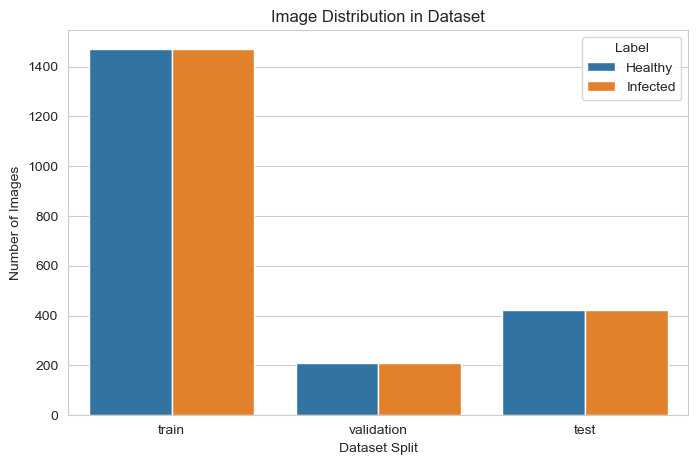

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [24]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [25]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [28]:
batch_size = 32  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [30]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [32]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(32, 128, 128, 3)


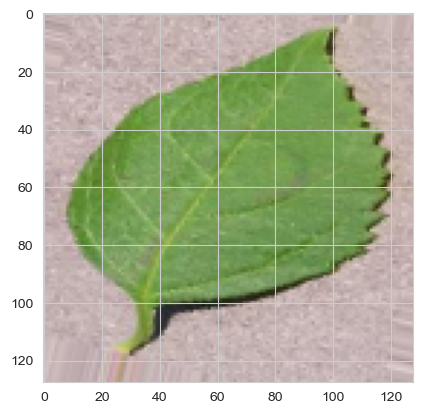

(32, 128, 128, 3)


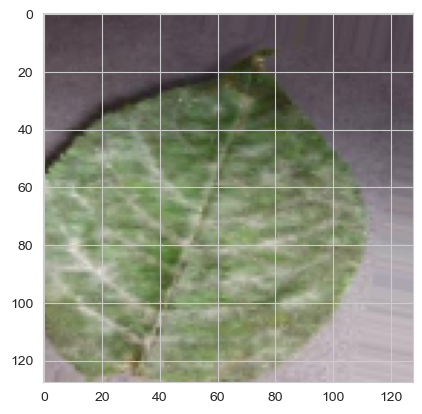

(32, 128, 128, 3)


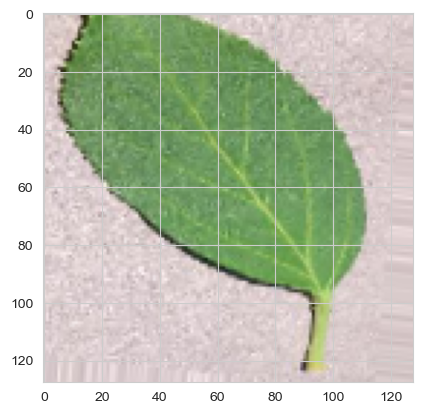

In [34]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(32, 128, 128, 3)


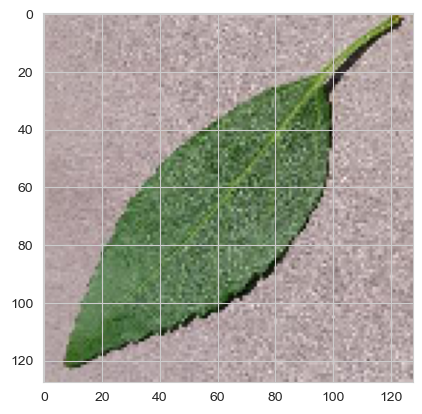

(32, 128, 128, 3)


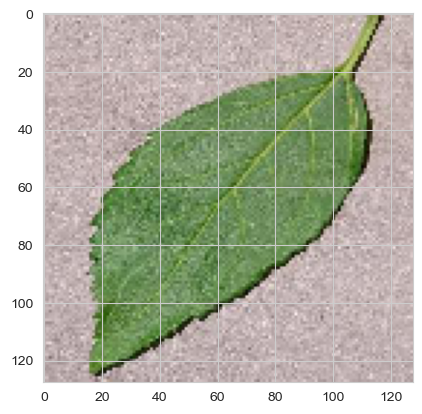

(32, 128, 128, 3)


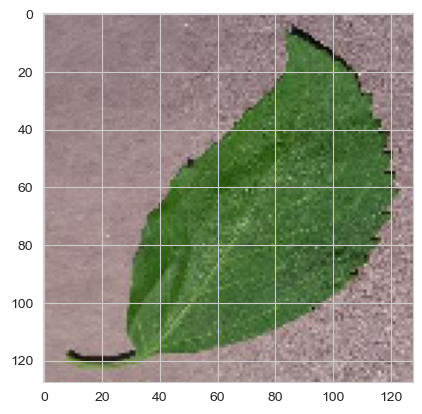

In [36]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(32, 128, 128, 3)


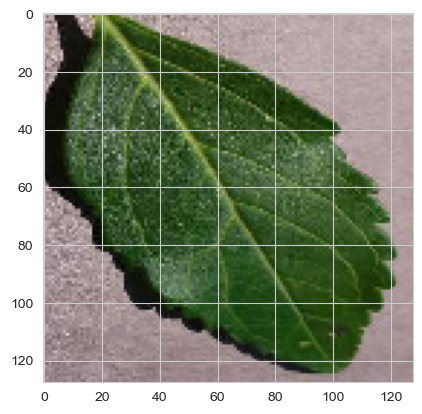

(32, 128, 128, 3)


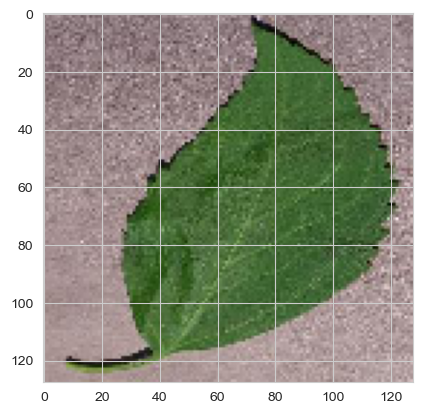

(32, 128, 128, 3)


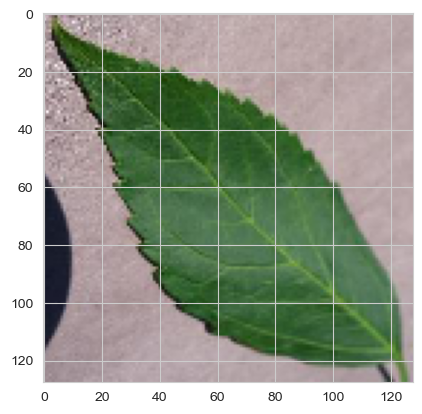

In [38]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [40]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

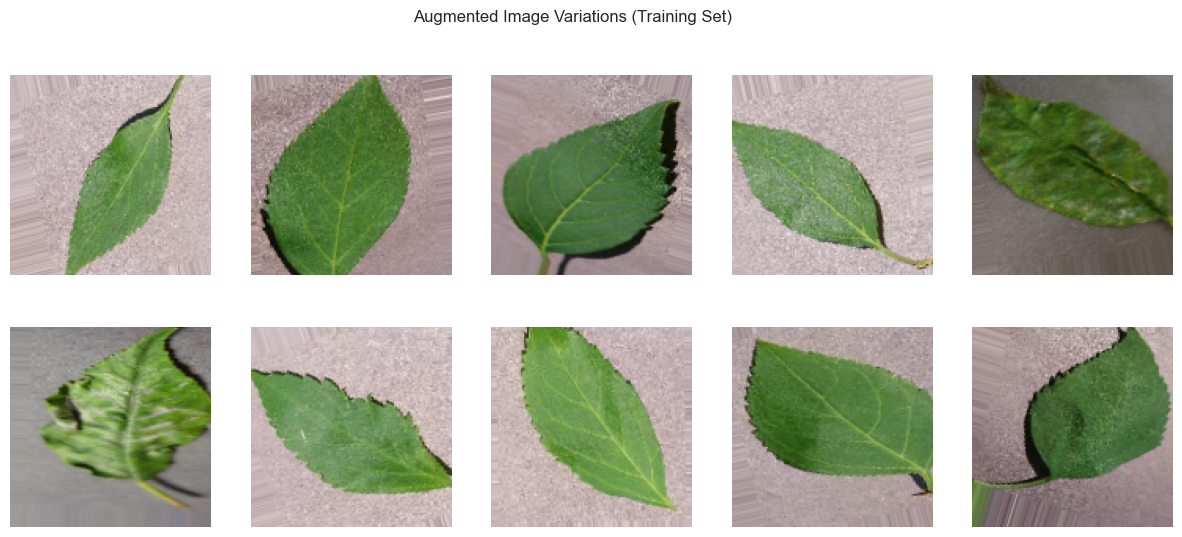

In [42]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [ ]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## Softmax

MobileNetV2 was chosen for its efficiency, speed, and strong feature extraction while maintaining high accuracy with fewer parameters. Its lightweight architecture makes it ideal for deployment in resource-constrained environments. Details are provided in the README.

In [ ]:
# Define hyperparameter
learning_rate = 0.000075
l2_lambda = 0.002
dropout_rate = 0.35
activation_function = "relu"
patience_value = 5

# Create Softmax CNN Model
model_softmax = Sequential(
    [
        Input(shape=(128, 128, 3)),
        Conv2D(16, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation_function),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation=activation_function, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(2, activation="softmax"),
    ]
)

# Compile Model
model_softmax.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Model Summary

In [ ]:
# Print Model Summary
model_softmax.summary()

---

## Model Training

### Early Stopping Implementation

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set EarlyStopping & Learning Rate Scheduler
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_value, restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6
)

### Fit Model for Training

In [ ]:
# Train the Softmax CNN Model
history_softmax = model_softmax.fit(
    train_set,  
    epochs=10,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1,
)

### Save Model

In [ ]:
model_softmax.save("outputs/v1/softmax.h5")

---

# Model Performance

---

## Learning Curves 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

sns.set_style("whitegrid")

# Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(history_softmax.history["loss"], "o-", label="Training Loss")
plt.plot(history_softmax.history["val_loss"], "o-", label="Validation Loss")
plt.title("Loss Curve - Softmax CNN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{output_dir}/loss_curve_softmax.png")
plt.show()

# Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(history_softmax.history["accuracy"], "o-", label="Training Accuracy")
plt.plot(history_softmax.history["val_accuracy"], "o-", label="Validation Accuracy")
plt.title("Accuracy Curve - Softmax CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{output_dir}/accuracy_curve_softmax.png")
plt.show()

### Learning Curves - Insights

#### **Loss Curve**
- The training and validation loss decrease smoothly, showing consistent learning.  
- The validation loss stabilizes after a few epochs, indicating no major overfitting.  

#### **Accuracy Curve**
- Both training and validation accuracy steadily increase and converge near **99%**.  
- This confirms strong generalization without signs of divergence.  

---

# Model Evaluation

### Import Packages

In [ ]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

### Load Saved Model

In [ ]:
from keras.models import load_model

# Load the model
model = load_model("outputs/v1/softmax.h5")

## Evaluation on Test Set

In [ ]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ", evaluation[0])

## Set Accuracy Variables

In [ ]:
# Correctly obtain true labels
y_true = test_set.labels

# Obtain model predictions
preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)

## Histograms

The histogram below shows the overall distribution of model confidence scores for predictions on the test set. To explore individual image confidence levels and analyze misclassifications, please refer to the interactive version in the Streamlit dashboard.

In [ ]:
import numpy as np
import plotly.graph_objects as go
import os

output_dir = "outputs/v1"

# Get predicted probabilities
y_pred_probs = model_softmax.predict(validation_set)

# Create DataFrame for Plotly
df_probs = {"Healthy": y_pred_probs[:, 0], "Infected": y_pred_probs[:, 1]}

# Create histogram traces for both classes
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=df_probs["Healthy"],
        nbinsx=20,
        opacity=0.6,
        name="Healthy",
        marker_color="green",
    )
)

fig.add_trace(
    go.Histogram(
        x=df_probs["Infected"],
        nbinsx=20,
        opacity=0.6,
        name="Infected",
        marker_color="blue",
    )
)

# Add threshold line at 0.5
fig.add_trace(
    go.Scatter(
        x=[0.5, 0.5],
        y=[
            0,
            max(np.histogram(y_pred_probs[:, 1], bins=20)[0]),
        ],  # Adjust y-axis dynamically
        mode="lines",
        name="Threshold = 0.5",
        line=dict(color="red", dash="dash"),
    )
)

# Update layout
fig.update_layout(
    title="Prediction Probability Histogram",
    xaxis_title="Prediction Probability",
    yaxis_title="Count",
    barmode="overlay",
    template="plotly_white",
)

# Save the figure as a static PNG
fig.write_image(os.path.join(output_dir, "histogram_test.png"), scale=2)

# Show the interactive plot
fig.show()

print(f"Histogram saved at: {output_dir}/histogram_test.png")

### Prediction Probability Histogram - Insights

- The predicted probabilities are strongly concentrated around **0 or 1**, indicating high model confidence.  
- Minimal overlap between the two classes suggests that the decision boundary is well-defined.  

## Confusion Matrix

In [ ]:
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import os
from sklearn.metrics import confusion_matrix

output_dir = "outputs/v1"

# Get Class Labels
label_map = list(test_set.class_indices.keys())

# Evaluate Model on Train and Test Sets
y_true_train = train_set.classes
y_pred_train = np.argmax(model_softmax.predict(train_set), axis=1)

y_true_test = test_set.classes
y_pred_test = np.argmax(model_softmax.predict(test_set), axis=1)

# Generate Confusion Matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Convert confusion matrices to DataFrames
df_cm_train = pd.DataFrame(cm_train, index=label_map, columns=label_map)
df_cm_test = pd.DataFrame(cm_test, index=label_map, columns=label_map)


# Function to create interactive Confusion Matrix
def create_confusion_matrix_figure(conf_matrix, title):
    fig = ff.create_annotated_heatmap(
        z=conf_matrix.values,
        x=conf_matrix.columns.tolist(),
        y=conf_matrix.index.tolist(),
        colorscale="Blues",
        showscale=True,
    )

    fig.update_layout(
        title=title,
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        template="plotly_white",
    )
    return fig


# Create interactive plots
fig_train = create_confusion_matrix_figure(df_cm_train, "Confusion Matrix - Train Set")
fig_test = create_confusion_matrix_figure(df_cm_test, "Confusion Matrix - Test Set")

# Save Figures
fig_train.write_image(os.path.join(output_dir, "confusion_matrix_train.png"), scale=2)
fig_test.write_image(os.path.join(output_dir, "confusion_matrix_test.png"), scale=2)

fig_train.show()
fig_test.show()

print(
    f"Confusion Matrices saved at: {output_dir}/confusion_matrix_train.png & {output_dir}/confusion_matrix_test.png"
)

### Confusion Matrix - Insights

- The **train set confusion matrix** shows a well-balanced classification, with very few misclassifications.  
- The **test set confusion matrix** confirms strong generalization, as misclassification counts remain low, indicating that the model is not overfitting.  

## Classification Reports

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import os

output_dir = "outputs/v1"

# Generate classification reports as dictionaries
report_train = classification_report(
    y_true_train, y_pred_train, target_names=label_map, output_dict=True
)
report_test = classification_report(
    y_true_test, y_pred_test, target_names=label_map, output_dict=True
)

# Convert to DataFrame
df_train = pd.DataFrame(report_train).transpose().round(3)
df_test = pd.DataFrame(report_test).transpose().round(3)

# Print Train Report
print("\n### Classification Report - Train Set ###\n")
print(df_train)

# Print Test Report
print("\n### Classification Report - Test Set ###\n")
print(df_test)

# Save reports as CSV for future reference
df_train.to_csv(f"{output_dir}/classification_report_train.csv")
df_test.to_csv(f"{output_dir}/classification_report_test.csv")

print(
    f"\nReports saved to {output_dir}/classification_report_train.csv & {output_dir}/classification_report_test.csv"
)

### Classification Report - Insights

- The **train set classification report** shows a balanced precision, recall, and F1-score, indicating that the model effectively learns from training data.  
- The **test set classification report** confirms strong generalization, with nearly identical metrics across both classes, ensuring reliable performance on unseen data.  

## ROC Curves

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import os

# Ensure output directory exists
output_dir = "outputs/v1"
os.makedirs(output_dir, exist_ok=True)

# Generate predictions (probabilities)
y_probs_train = model_softmax.predict(train_set)
y_probs_test = model_softmax.predict(test_set)

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_probs_test[:, 1])

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Create interactive ROC Curve using Plotly
fig = go.Figure()

# Train ROC Curve
fig.add_trace(
    go.Scatter(
        x=fpr_train,
        y=tpr_train,
        mode="lines",
        name=f"Train AUC = {auc_train:.2f}",
        line=dict(color="blue"),
    )
)

# Test ROC Curve
fig.add_trace(
    go.Scatter(
        x=fpr_test,
        y=tpr_test,
        mode="lines",
        name=f"Test AUC = {auc_test:.2f}",
        line=dict(color="green"),
    )
)

# Random Guess Line (Baseline)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random (AUC = 0.50)",
        line=dict(color="black", dash="dash"),
    )
)

# Update layout
fig.update_layout(
    title="ROC Curve - Train vs Test",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_white",
    legend=dict(x=0.7, y=0.2),
)

# Save the figure as a static PNG
roc_curve_path = os.path.join(output_dir, "roc_curve.png")
fig.write_image(roc_curve_path, scale=2)

# Show interactive plot
fig.show()

print(f"ROC Curve saved at: {roc_curve_path}")

### ROC Curve - Insights

- The **train ROC curve** demonstrates a high True Positive Rate (TPR) with minimal False Positive Rate (FPR), indicating strong discrimination ability.  
- The **test ROC curve** closely follows the train curve, confirming that the model maintains high performance on unseen data without signs of overfitting.  

### Model Performance & Overfitting Analysis

- The model achieved **99.64% accuracy** with a **low loss of 0.1486**, demonstrating strong performance.  
- The **learning curves** confirm smooth convergence with no signs of major overfitting.  
- The **confusion matrix and classification report** highlight minimal misclassification and high precision/recall.  
- The **ROC curve** supports excellent class separation, ensuring the model generalizes well.  
- Given these results, the model is **ready for deployment** with reliable predictive power.  

## Save Evaluation Pickle

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

## Business Goal Validation

In [ ]:
# Load evaluation results
evaluation_results = joblib.load("outputs/v1/evaluation.pkl")

# Extract final test accuracy
test_accuracy = evaluation_results[1]  

# Check requirement
accuracy_threshold = 0.90
if test_accuracy >= accuracy_threshold:
    print(f"Model meets the business requirement! (Accuracy: {test_accuracy:.2%})")
else:
    print(f"Model does NOT meet the requirement. (Accuracy: {test_accuracy:.2%})")

---

# Predict on New Images

---

## Load random image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] 
pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/' + label)[pointer],
                            target_size= image_shape, color_mode='rgb')

print(f" Image shape: {pil_image.size}, Image mode: {pil_image.mode}")
pil_image

### Convert Image to Array and Prepare for Model Input

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  
print(my_image.shape)

### Predict class probabilities

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

---

# Conclusion and Next Steps

---


We successfully developed a deep learning model for image classification using a structured, beginner-friendly approach.  

### **Key Achievements**
- **Explored Multiple Architectures** → Compared Sigmoid, Softmax, and MobileNetV2 across different trials.  
- **Comprehensive Evaluation** → Assessed models using accuracy, loss, confusion matrices, and ROC curves.  
- **Optimized for Generalization** → Selected the best-performing model with minimal overfitting.  
- **Deployment-Ready Model** → Finalized MobileNetV2 for real-world application.  

### **Next Steps: Model Deployment**
- **Web App Integration** → Implement a user-friendly Streamlit interface for real-time image classification.  
- **Model Deployment** → Load the trained model and deploy it on a cloud platform for accessibility.  

This deployment will enable efficient real-world usage, making automated classification accessible to users.  